In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from sklearn.metrics import precision_recall_fscore_support, classification_report, RocCurveDisplay, roc_auc_score, roc_curve, ConfusionMatrixDisplay, \
    precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
import random
import os

In [ ]:
with open('../Data/modeling_results_large.pkl', 'rb') as f:
    cv_results = pickle.load(f)
cv_results.keys()

In [ ]:
with open('../Data/preprocessed.pkl.zip', 'rb') as f:
    _ = pickle.load(f)
    col_names = pickle.load(f)
    X = pickle.load(f)
    y = pickle.load(f)
    cat_slice = pickle.load(f)
    skewed_slice = pickle.load(f)
    non_skewed_slice = pickle.load(f)

    X_train = pickle.load(f)
    X_test = pickle.load(f)
    y_train = pickle.load(f)
    y_test = pickle.load(f)    

In [ ]:
col_names, X.shape, y.shape, cat_slice, skewed_slice, non_skewed_slice

In [27]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #X_cat = X[:, cat_slice]
        #X_skewed = X[:, skewed_slice]
        #X_non_skewed = X[:, non_skewed_slice]
        
        #q_transformer = QuantileTransformer()
        #q_transformer.fit(X_skewed)

        X = sparse.hstack([X[:, cat_slice], QuantileTransformer().fit_transform(X[:, skewed_slice]), X[:, non_skewed_slice]], format='csr')
        
        #Making the matrices dense
        #X_non_skewed_dense = X_non_skewed.toarray()

        #Initializing and fitting the scaler
        #scaler = StandardScaler()
        #scaler.fit(X_non_skewed_dense)

        #Applying the scaling t+
        # eo the dense matrices
        #X_non_skewed_dense = scaler.transform(X_non_skewed_dense)

        #Making the matrices sparse again
        #X_non_skewed = sparse.csr_matrix(X_non_skewed_dense)
        
        #X_non_skewed = sparse.csr_matrix(StandardScaler().fit_transform(X[:, non_skewed_slice].toarray())) 
        X = sparse.hstack([X[:, cat_slice], X[:, skewed_slice], sparse.csr_matrix(StandardScaler().fit_transform(X[:, non_skewed_slice].toarray()))], format='csr')
        
        #del X_non_skewed
        
        #X = sparse.hstack([X_cat, X_skewed, X_non_skewed])
        
        return X

In [ ]:
pipeline = Pipeline([('transformation', CustomTransformer()), ('log_regression', LogisticRegression(max_iter=10000))])

In [ ]:
%%time

cv_scores = cross_val_score(pipeline, X, y, scoring='roc_auc')

In [ ]:
cv_scores

In [ ]:
with open('../Data/cv_scores_large.pkl', 'wb') as f:
    pickle.dump(cv_scores, f)

In [72]:
path = '../Data/first_log_model.pkl'
if not os.path.exists(path):
    logistic_regressor = LogisticRegression(max_iter=10000, class_weight='balanced')
    logistic_regressor.fit(X_train, y_train)
    with open(path, 'wb') as f:
        pickle.dump(logistic_regressor, f)
else:
    with open(path, 'rb') as f:
        logistic_regressor = pickle.load(f)

In [73]:
coef = logistic_regressor.coef_[0]
y_pred_train = logistic_regressor.predict(X_train)
y_proba_train = logistic_regressor.predict_proba(X_train)[:, 1]
y_pred = logistic_regressor.predict(X_test)
y_proba = logistic_regressor.predict_proba(X_test)[:, 1]

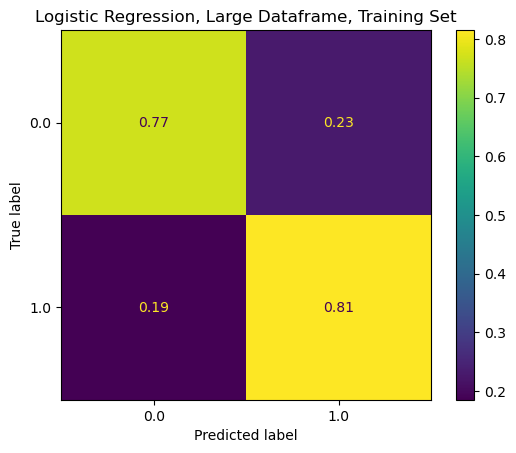


Classification Report: Logistic Regression, Large Dataframe, Training Set
              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86    319105
         1.0       0.25      0.81      0.39     30906

    accuracy                           0.77    350011
   macro avg       0.62      0.79      0.62    350011
weighted avg       0.91      0.77      0.82    350011




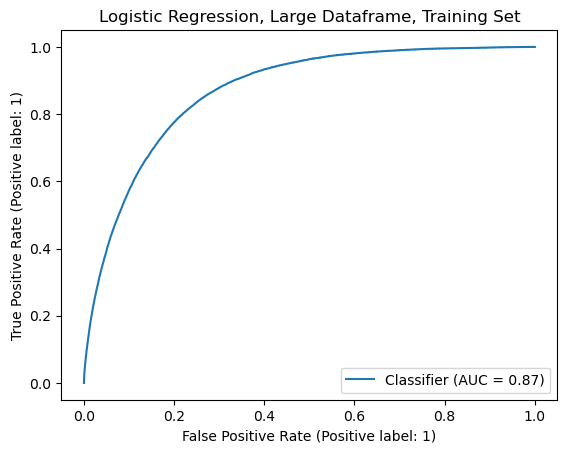

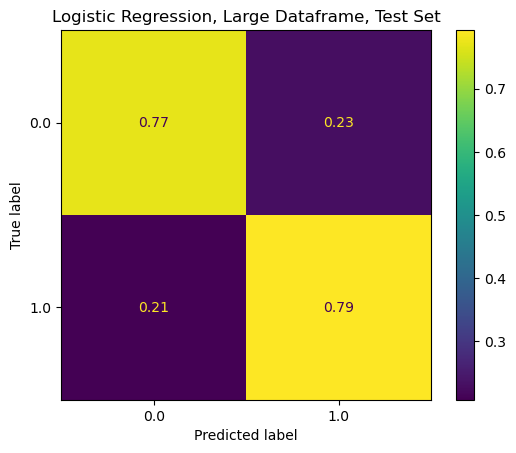


Classification Report: Logistic Regression, Large Dataframe, Test Set
              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86     79776
         1.0       0.25      0.79      0.38      7727

    accuracy                           0.77     87503
   macro avg       0.61      0.78      0.62     87503
weighted avg       0.91      0.77      0.82     87503




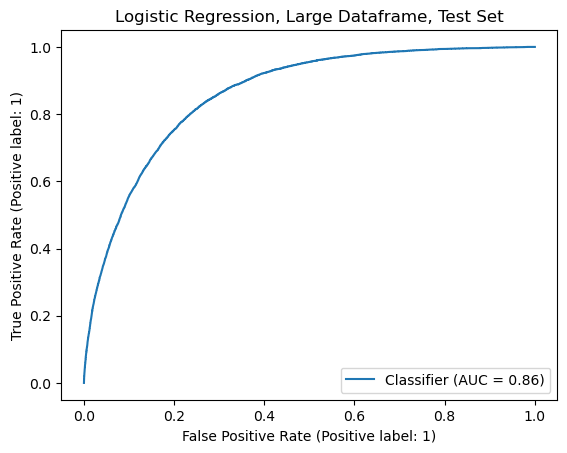

In [74]:
_ = my_scorer(y_train, y_pred_train, y_proba_train, model_name='Logistic Regression, Large Dataframe, Training Set')
_ = my_scorer(y_test, y_pred, y_proba, model_name='Logistic Regression, Large Dataframe, Test Set')

In [63]:
help(find_threshold)

Help on function find_threshold in module __main__:

find_threshold(y_true, y_proba, set_tpr, sample_weight=None)



In [64]:
_, thresh = find_threshold(y_test, y_proba, 0.80)
thresh

0.09054462682202445

In [70]:
y_pred_thresh = (y_proba >= thresh).astype('float')

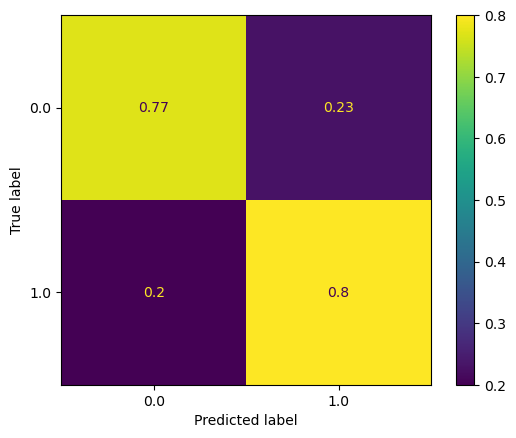


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86     79776
         1.0       0.25      0.80      0.38      7727

    accuracy                           0.77     87503
   macro avg       0.61      0.79      0.62     87503
weighted avg       0.91      0.77      0.82     87503




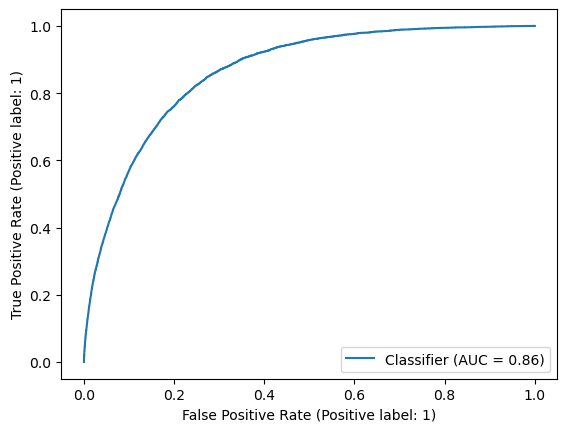

In [71]:
_ = my_scorer(y_test, y_pred_thresh, y_proba)

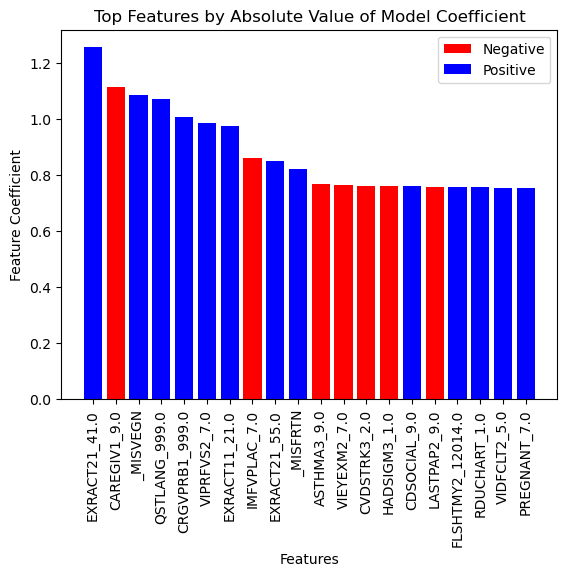

In [53]:
plot_linear_feature_importances(coef, col_names, 20)

In [28]:
def plot_linear_feature_importances(coefficients, feature_names, number):
    indices_sorted = np.argsort(np.abs(coefficients))[:(-1) * number - 1:-1]
    top_coef = coefficients[indices_sorted]
    labels = feature_names[indices_sorted]
    
    neg_pos = np.where(top_coef < 0)[0]
    pos_pos = np.where(top_coef >= 0)[0]
    neg_coef = top_coef[neg_pos]
    pos_coef = top_coef[pos_pos]
    neg_names = labels[neg_pos]
    pos_names = labels[pos_pos]
    
    _, ax = plt.subplots()
    
    ax.bar(neg_pos, np.abs(neg_coef), color='r', label='Negative')
    ax.bar(pos_pos, np.abs(pos_coef), color='b', label='Positive')
    ax.set_xticks(range(0, len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title('Top Features by Absolute Value of Model Coefficient')
    ax.set_ylabel('Feature Coefficient')
    ax.set_xlabel('Features')
    
    ax.legend()
    plt.show()

In [ ]:
cv_score_list = cross_val_score(logistic_regressor, X_train, y_train, scoring='roc_auc')
print(f'CV scores: {cv_score_list}\nAverage: {cv_score_list.mean()}\nStandard Deviation: {cross_val_score.std()}')

In [ ]:
print(f'CV Scores: {cv_score_list}\nAverage: {cv_score_list.mean()}\nStandard Deviation: {cv_score_list.std()}')

In [ ]:
class LogisticRegressionCustom(LogisticRegression):
    def __init__(self, max_iter=100, class_weight=None, threshold=None):
        super().__init__(max_iter=max_iter, class_weight=class_weight)
        self.threshold = threshold
    
    def predict(self, X):
        if self.threshold != None:
            return (super().predict_proba(X)[:, 1] >= self.threshold).astype(int)
        else:
            return super().predict(X)

In [ ]:
def plot_logistic_feature_importance(coefficients, feature_names, number):
    coef_enum = enumerate(coefficients)
    coef_enum_sorted_top = sorted(coef_enum, key=lambda x: abs(x[1]), reverse=True)[:number]
    
    indices = list(list(zip(*coef_enum_sorted_top))[0])
    names = feature_names[indices]
    top_coef = np.array(list(zip(*coef_enum_sorted_top))[1])
    
    neg_pos = np.where(top_coef < 0)[0]
    pos_pos = np.where(top_coef >= 0)[0]
    neg_coef = top_coef[neg_pos]
    pos_coef = top_coef[pos_pos]
    neg_names = names[neg_pos]
    pos_names = names[pos_pos]
    
    _, ax = plt.subplots()
    
    ax.bar(neg_pos, np.abs(neg_coef), color='r', label='Negative')
    ax.bar(pos_pos, np.abs(pos_coef), color='b', label='Positive')
    ax.set_xticks(range(0, len(names)))
    ax.set_xticklabels(names, rotation=90)
    ax.set_title('Top Features by Absolute Value of Model Coefficient')
    ax.set_ylabel('Feature Coefficient')
    ax.set_xlabel('Features')
    
    ax.legend()
    plt.show()

In [60]:
def find_threshold(y_true, y_proba, set_tpr, sample_weight=None):
    _, tpr_list, threshold_list = roc_curve(y_true, y_proba, sample_weight=sample_weight)
    for tpr, threshold in zip(tpr_list, threshold_list):
        if (tpr >= set_tpr):
            return tpr, threshold

In [44]:
def my_scorer(y_test, y_pred, y_pred_proba=None, sample_weight=None, model_name=None, output=True):
    prfs_scores = precision_recall_fscore_support(y_test, y_pred, sample_weight=sample_weight)
    roc_auc_score_ = roc_auc_score(y_test, y_pred, sample_weight=sample_weight)
    scores = *prfs_scores, roc_auc_score_
    
    cf_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize = 'true')
    if output == True:
        if type(model_name) != type(None):
            plt.title(model_name)
        plt.show()
        print()
        
    if output == True:
        print(f'Classification Report: {model_name if type(model_name) != type(None) else ""}')
    class_report = classification_report(y_test, y_pred, sample_weight=sample_weight)
    if output == True:
        print(class_report)
        print()
    
    if type(y_pred_proba) != type(None):
        roc_display = RocCurveDisplay.from_predictions(y_test, y_pred_proba, sample_weight=sample_weight)
        if output == True:
            if model_name != None:
                plt.title(model_name)
            plt.show()
    else:
        roc_display = None
        
    return scores, (cf_display, class_report, roc_display)

In [56]:
def my_pipeline(ml_algo, *data, model_name='Model', algo_params={}, resampler=None, split_params={}, output=True):
    if len(data) not in [2, 3]:
        print(f'Invalid length for "data": {len(data)}.')
        return
    
    results = {}
    
    split_result = train_test_split(*data, **split_params)
    if len(split_result) == 4:
        X_train, X_test, y_train, y_test = split_result
        w_train = None
        w_test = None
    elif len(split_result) == 6:
        X_train, X_test, y_train, y_test, w_train, w_test = split_result
    else:
        print('Invalid length for "split_result".')
        return
        
    if type(resampler) != type(None):
        X_train, y_train = resampler().fit_resample(X_train, y_train)
    
    model = ml_algo(**algo_params)
    model.fit(X_train, y_train, sample_weight=w_train)
    results['model_info'] = model_name, model
    
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = None
        y_pred_proba = None
        
    results['predictions_train'] = y_pred_train, y_pred_proba_train
    results['predictions'] =y_pred, y_pred_proba
    
    results['scores_train'], results['displays_train'] = my_scorer(y_train, y_pred_train, y_pred_proba_train, sample_weight=w_train, model_name=model_name + ' (train)', output=output)
    results['scores'], results['displays'] = my_scorer(y_test, y_pred, y_pred_proba, sample_weight=w_test, model_name=model_name, output=output)
    
    return results


In [ ]:
def cv_scorer(ml_algo, scoring, *data, model_name=None, algo_params={}, resampler=None, output=True):    
    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if type(resampler) != type(None):
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo(**algo_params))])
    else:
        model = Pipeline([(model_name, ml_algo(**algo_params))])
    
    cv_scores = cross_validate(model, X, y, scoring=scoring, fit_params={model_name + '__sample_weight':w}, return_estimator=True)
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    cv_scores_summary = {}
    cv_scores_summary['estimator'] = cv_scores['estimator']
    for score in scoring:
        scores_ = cv_scores['test_' + score]
        mean_ = cv_scores['test_' + score].mean()
        std_ = cv_scores['test_' + score].std()
        
        cv_scores_summary[score]= dict(zip(['scores', 'mean', 'std'], [scores_, mean_, std_]))
        
        if output == True:
            print(score + ' mean: ' + f'{mean_:0.2f}')
            print(score + ' std: ' + f'{std_:0.4f}')
            print()
    if print == True:
        print()
    
    if type(model_name) != type(None):
        return {model_name:cv_scores_summary}, cv_scores
    else:
        return cv_scores_summary, cv_scores

In [ ]:
def grid_cv_scorer(ml_algo, scoring, *data, model_name=None, param_grid={}, resampler=None, output=True):    
    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if type(resampler) != type(None):
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo())])
    else:
        model = Pipeline([(model_name, ml_algo())])
        
    keys = [k for k in param_grid.keys()]
    for key in keys:
        param_grid[model_name + '__' + key] = param_grid.pop(key)
    
    clf = GridSearchCV(model, param_grid=param_grid, scoring=scoring, refit=False)
    clf.fit(X, y, CVSearch_Test__sample_weight=w)
    cv_scores = clf.cv_results_
    print('Printing cv_scores keys:')
    print(cv_scores.keys())
    print('Printing cv_scores:')
    print(cv_scores)
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    cv_scores_summary = {}
    #dict_scores['estimator'] = cv_scores['estimator']
    for score in scoring:
        #scores_ = cv_scores['test_' + score]
        mean_array = cv_scores['mean_test_' + score]
        std_array = cv_scores['std_test_' + score]
        
        cv_scores_summary[score]= dict(zip(['mean', 'std'], [mean_array, std_array]))
        
        if output == True:
            print(score + ' mean: ', mean_array)
            print(score + ' std: ', std_array)
            print()
    if print == True:
        print()
    
    if type(model_name) != type(None):
        return {model_name:cv_scores_summary}
    else:
        return cv_scores_summary, cv_scores

In [ ]:
def plot_feature_importance(importances, labels, title=None, num=20):
    num = num * (-1) - 1
    indices = importances.argsort()[:num:-1]
    plt.bar(x=labels[indices], height=importances[indices])
    plt.xticks(rotation=90)
    if type(title) != type(None):
        plt.title(title)
    plt.show()

In [ ]:
precision_score_pos = make_scorer(precision_score, pos_label=1)
precision_score_neg = make_scorer(precision_score, pos_label=0)

recall_score_pos = make_scorer(recall_score, pos_label=1)
recall_score_neg = make_scorer(recall_score, pos_label=0)

f1_score_pos = make_scorer(f1_score, pos_label=1)
f1_score_neg = make_scorer(f1_score, pos_label=0)

roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

In [ ]:
%%time
algo_list = {'Logistic Regression':LogisticRegressionCustom, 'Random Forest':RandomForestClassifier, 'XGBoost':XGBClassifier}
algo_params_list = [dict(max_iter=1000000), dict(n_estimators=100), {}]
imbalance_strategy_list = {'Basic':None, 'Class Weight':None, 'Random Oversampling':RandomOverSampler, 'SMOTE':SMOTE, 'Random Undersampling':RandomUnderSampler}
scores = {'precision_pos':precision_score_pos, 'precision_neg':precision_score_neg, 'recall_pos':recall_score_pos, 'recall_neg':recall_score_neg, \
    'f1_pos':f1_score_pos, 'f1_neg':f1_score_neg, 'roc_auc':roc_auc_scorer}

cv_results = {}

for algo_name, algo_params in zip(algo_list, algo_params_list):
    for resampler_name, resampler in imbalance_strategy_list.items():
        if resampler_name == 'Basic':
            data = X, y, w
        else:
            data = X, y
        if (resampler_name == "Class Weight") and (algo_name != 'XGBoost'):
            algo_params['class_weight'] = 'balanced'
            
        cv_results.update(cv_scorer(algo_list[algo_name], scores, *data, model_name=algo_name+', '+resampler_name, algo_params=algo_params, resampler=resampler)[0])
        
        with open('../Data/modeling_results_large.pkl', 'wb') as f:
            pickle.dump(cv_results, f)


In [ ]:
def results_to_df(cv_results):
    columns = []
    for score in cv_results[list(cv_results.keys())[0]].keys():
        if score != 'estimator':
            columns.append(score + '_mean')
            columns.append(score + '_std')
    
    data = []
    index = []
    for model_name in cv_results:
        index.append(model_name)
        row = []
        for score in cv_results[model_name]:
            if score != 'estimator':
                row.append(cv_results[model_name][score]['mean'])
                row.append(cv_results[model_name][score]['std'])
        data.append(row)
        
    return pd.DataFrame(data, index=index, columns=columns)

In [ ]:
results_df = results_to_df(cv_results)
results_df

In [ ]:
with open('../Data/modeling_results_large.pkl', 'rb') as f:
    cv_results = pickle.load(f)

In [ ]:
cv_results.keys()

In [ ]:
%%time
algo_list = {'Logistic Regression':LogisticRegressionCustom, 'Random Forest':RandomForestClassifier, 'XGBoost':XGBClassifier}
algo_params_list = [dict(max_iter=1000000), dict(n_estimators=100), {}]
imbalance_strategy_list = {'Basic':None, 'Class Weight':None, 'Random Oversampling':RandomOverSampler, 'SMOTE':SMOTE, 'Random Undersampling':RandomUnderSampler}
scores = {'precision_pos':precision_score_pos, 'precision_neg':precision_score_neg, 'recall_pos':recall_score_pos, 'recall_neg':recall_score_neg, \
    'f1_pos':f1_score_pos, 'f1_neg':f1_score_neg, 'roc_auc':roc_auc_scorer}

for algo_name, algo_params in zip(algo_list, algo_params_list):
    if algo_name == 'Logistic Regression':
        continue
    for resampler_name, resampler in imbalance_strategy_list.items():
        if (algo_name == 'Random Forest') and (resampler_name in ['Basic', 'Class Weight']):
            continue
        
        if resampler_name == 'Basic':
            data = X, y, w
        else:
            data = X, y
        if resampler_name == "Class Weight":
            if algo_name == 'XGBoost':
                continue
            else:
                algo_params['class_weight'] = 'balanced'
        
        print('Now running:', algo_name + ', ' + resampler_name)
        cv_results.update(cv_scorer(algo_list[algo_name], scores, *data, model_name=algo_name+', '+resampler_name, algo_params=algo_params, resampler=resampler)[0])
        
        with open('../Data/modeling_results_large.pkl', 'wb') as f:
            pickle.dump(cv_results, f)